In [1]:
import os
from glob import glob
import multiprocessing as mp

import numpy as np
import pandas as pd
import platform
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.widgets
from matplotlib.animation import FuncAnimation, PillowWriter
import mpl_toolkits.axes_grid1
from mpl_toolkits.axes_grid1 import Size
import shutil

from starcraft.Colors import *
from starcraft.UnitType import *

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
SCREEN_WIDTH, SCREEN_HEIGHT = 640, 384
TILE_SIZE = 32
FPS = 24
INTERVAL = 8

# cpu_count = int(mp.cpu_count())
# num_workers = int(cpu_count * 0.8)

In [3]:
def preprocess_raw_data(dataframe):
    dataframe['x_tile'] = dataframe['x'].apply(lambda x: x // TILE_SIZE)
    dataframe['y_tile'] = dataframe['y'].apply(lambda x: x // TILE_SIZE)
    dataframe['left_tile'] = dataframe['left'].apply(lambda x: x / TILE_SIZE)
    dataframe['right_tile'] = dataframe['right'].apply(lambda x: x / TILE_SIZE)
    dataframe['top_tile'] = dataframe['top'].apply(lambda x: x / TILE_SIZE)
    dataframe['bottom_tile'] = dataframe['bottom'].apply(lambda x: x / TILE_SIZE)
    
    dataframe['left_tile'] = np.round(dataframe['left_tile'])
    dataframe['right_tile'] = np.round(dataframe['right_tile'])
    dataframe['top_tile'] = np.round(dataframe['top_tile'])
    dataframe['bottom_tile'] = np.round(dataframe['bottom_tile'])
    
    dataframe['width_tile'] = dataframe['right_tile'] - dataframe['left_tile']
    dataframe['height_tile'] = dataframe['bottom_tile'] - dataframe['top_tile']

    ## race is Zerg when player is Neutral
    dataframe.loc[dataframe['player'] == 'Neutral', 'race'] = 'None'
    dataframe.loc[dataframe['player'] == 'Neutral', 'player_color'] = 'Cyan'
    
    return dataframe
    # print('players: ', dataframe['player'].unique())
    # print('player colors: ', dataframe['player_color'].unique())
    # print('races: ', dataframe['race'].unique())
    # dataframe.head()

In [4]:
def preprocess_terrain_in_pixel(terrain_tile):
    terrain = list()
    for h in range(terrain_tile.shape[0]):
        tmp_row = np.hstack([np.asarray([terrain_tile[h][w]] * TILE_SIZE) for w in range(terrain_tile.shape[1])])
        tmp_row = np.vstack([tmp_row] * TILE_SIZE)
        terrain.append(tmp_row)
    terrain = np.concatenate(terrain)
    return terrain

In [5]:
def preprocess_vision_data(dataframe, terminal_frame):
    ## terminal_frame까지 ffill로 보간
    dataframe = dataframe.set_index('frame')
    dataframe = dataframe.reindex(range(terminal_frame))
    dataframe = dataframe.fillna(method='ffill')
    dataframe = dataframe.reset_index()
    return dataframe

In [6]:
def load_data(replay_name):
    df_raw = pd.read_csv(data_dir + replay_name + ".raw", index_col=None)
    df_raw = preprocess_raw_data(df_raw)
    
    # print('# of All data over time: ', len(df_raw))
    players_in_frame = df_raw.loc[df_raw['player'] != 'Neutral'][['frame', 'player']].groupby(['frame', 'player'], as_index=False).agg('count')
    players_in_frame = players_in_frame.groupby('frame', as_index=False).agg('count')

    single_player_only = players_in_frame.loc[players_in_frame['player'] < 2]
    terminal_frame = single_player_only['frame'].min()
    if np.isnan(terminal_frame): terminal_frame = df_raw['frame'].max()
    
    df_vision = pd.read_csv(data_dir + replay_name + ".vision", index_col=None)
    df_vision = preprocess_vision_data(df_vision, terminal_frame)

    terrain_tile = np.genfromtxt(data_dir + replay_name + ".terrain", delimiter=',', dtype=int)
    terrain_pixel = preprocess_terrain_in_pixel(terrain_tile)
    # print('Terrain shape(TILE): ', terrain_tile.shape)
    # print('Terrain shape(PIXEL): ', terrain_pixel.shape)

    ## faster than list comprehension
    # last_t_index = df.groupby('frame', as_index=False).size()['size'].cumsum()
    # dataset = []
    # last_check = 0
    # for ind in last_t_index:
    #     dataset.append(df.loc[last_check:ind-1])
    #     last_check = ind
    
    return df_raw, terminal_frame, (terrain_pixel, terrain_tile), df_vision, 

In [7]:
def make_channels(dataframe):
    channel = dataframe.pivot_table('name', 'y_tile', 'x_tile', aggfunc='count')
    channel = channel.reindex(range(terrain_tile.shape[0]))
    channel = channel.T.reindex(range(terrain_tile.shape[1]))
    channel = channel.fillna(0).astype(int).T
    channel = np.asarray(channel)
    return channel

In [17]:
def make_player_channels(dataframe):
    if len(dataframe) == 0: return

    dataframe['isWorker'] = dataframe['name'].apply(lambda x: UnitType(x).isWorker)
    dataframe['isUnit'] = dataframe['name'].apply(lambda x: UnitType(x).isUnit)
    dataframe['isGround'] = dataframe['name'].apply(lambda x: UnitType(x).isGround)
    dataframe['isAir'] = dataframe['name'].apply(lambda x: UnitType(x).isAir)

    dataframe['isBuilding'] = dataframe['name'].apply(lambda x: UnitType(x).isBuilding)
    dataframe['isAddon'] = dataframe['name'].apply(lambda x: UnitType(x).isAddon)

    dataframe['isSpell'] = dataframe['name'].apply(lambda x: UnitType(x).isSpell)
    dataframe['isTrivial'] = dataframe['name'].apply(lambda x: UnitType(x).isTrivial)

    # units = dataframe.loc[dataframe['isUnit']]
    units_worker = dataframe.loc[dataframe['isWorker']]
    units_ground = dataframe.loc[dataframe['isGround']].loc[~dataframe['isWorker']].loc[~dataframe['isTrivial']]
    units_air = dataframe.loc[dataframe['isAir']]
    units_trivial = dataframe.loc[dataframe['isTrivial']]

    buildings = dataframe.loc[dataframe['isBuilding']]
    # addons = dataframe.loc[dataframe['isAddon']]

    spells = dataframe.loc[dataframe['isSpell']]

    channel_worker = make_channels(units_worker)
    channel_ground = make_channels(units_ground)
    channel_air = make_channels(units_air)
    channel_trivial = make_channels(units_trivial)
    channel_building = make_channels(buildings)
    channel_spell = make_channels(spells)

    return np.stack([channel_worker, channel_ground, channel_air, channel_trivial, channel_building, channel_spell])

In [18]:
def make_resource_channels(dataframe):
    if len(dataframe) == 0: return

    dataframe['isResource'] = dataframe.apply(lambda row: UnitType(row['name']).isResource, axis=1)
    resources = dataframe.loc[dataframe['isResource']]
    channel_resource = make_channels(resources) # (128, 128)
    return np.expand_dims(channel_resource, 0) # (1, 128, 128)

In [19]:
def raw_dataframe_into_channels(dataframe, tile_size=32):
    if len(dataframe) == 0: return
    
    players = list(dataframe['player'].unique())
    players.remove('Neutral')
    player1, player2 = players[0], players[1]
    
    player1_dataframe = dataframe.loc[dataframe['player'] == player1]
    player2_dataframe = dataframe.loc[dataframe['player'] == player2]
    neutral_dataframe = dataframe.loc[dataframe['player'] == 'Neutral']
    
    player1_channels = make_player_channels(player1_dataframe)
    player2_channels = make_player_channels(player2_dataframe)
    resource_channel = make_resource_channels(neutral_dataframe)
    
#     print('player 1: ', player1_channels.shape)
#     print('player 2: ', player2_channels.shape)
#     print('neutral(resource, terrain): ', neutral_channels.shape)
#     print(player1_channels.shape, player2_channels.shape, neutral_channels.shape)
    current_frame_channels = np.vstack([player1_channels, player2_channels, resource_channel])
    return current_frame_channels

In [20]:
def vision_dataframe_into_channel(dataframe, shape):
    vision = dataframe.iloc[0]['state']
    vision = np.array(list(vision)).astype(int)
    vision = vision.reshape(shape) # (HEIGHT, WIDTH)
    vision = np.expand_dims(vision, 0) # (1, HEIGHT, WIDTH)
    return vision
    # np.asarray(list(tb.iloc[t_frame * 24]['state'])).astype(int).reshape(terrain_tile.shape)    

In [21]:
def plot_samples(frame):
    ## player1 units, and buildings
    fig = plt.figure(figsize=(24, 6), dpi=100)
    fig.suptitle('Player 1')
    nrows, ncols = 1, 6
    
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.imshow(result[frame, 0], 'binary')
    ax1.set_title('worker')
    
    ax2 = fig.add_subplot(nrows, ncols, 2)
    ax2.imshow(result[frame, 1], 'binary')
    ax2.set_title('ground')
    
    ax3 = fig.add_subplot(nrows, ncols, 3)
    ax3.imshow(result[frame, 2], 'binary')
    ax3.set_title('air')
    
    ax4 = fig.add_subplot(nrows, ncols, 4)
    ax4.imshow(result[frame, 3], 'binary')
    ax4.set_title('trivial')
    
    
    ax5 = fig.add_subplot(nrows, ncols, 5)
    ax5.imshow(result[frame, 4], 'binary')
    ax5.set_title('building')
    ax6 = fig.add_subplot(nrows, ncols, 6)
    ax6.imshow(result[frame, 5], 'binary')
    ax6.set_title('spell')
    plt.show()

    ## player2 units, and buildings
    fig = plt.figure(figsize=(24, 6), dpi=100)
    nrows, ncols = 1, 6
    
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.imshow(result[frame, 6], 'binary')
    ax1.set_title('worker')
    
    ax2 = fig.add_subplot(nrows, ncols, 2)
    ax2.imshow(result[frame, 7], 'binary')
    ax2.set_title('ground')
    
    ax3 = fig.add_subplot(nrows, ncols, 3)
    ax3.imshow(result[frame, 8], 'binary')
    ax3.set_title('air')
    
    ax4 = fig.add_subplot(nrows, ncols, 4)
    ax4.imshow(result[frame, 9], 'binary')
    ax4.set_title('trivial')
    
    
    ax5 = fig.add_subplot(nrows, ncols, 5)
    ax5.imshow(result[frame, 10], 'binary')
    ax5.set_title('building')
    ax6 = fig.add_subplot(nrows, ncols, 6)
    ax6.imshow(result[frame, 11], 'binary')
    ax6.set_title('spell')
    plt.show()

    ## resources, vision, and terrain
    fig = plt.figure(figsize=(18, 6), dpi=100)
    fig.suptitle('Neutral')
    nrows, ncols = 1, 3
    ax1 = fig.add_subplot(nrows, ncols, 1)
    ax1.imshow(result[frame, 12], 'binary')
    ax1.set_title('resource field')
    ax2 = fig.add_subplot(nrows, ncols, 2)
    ax2.imshow(result[frame, 13], 'binary')
    ax2.set_title('vision')
    ax3 = fig.add_subplot(nrows, ncols, 3)
    ax3.imshow(result[frame, 14], 'binary')
    ax3.set_title('terrain')
    plt.show()

In [22]:
def preprocess_viewport_data(rep_name):
    ## viewport data missing frame 보간하여 저장
    viewport_data = pd.read_csv(data_dir + '{}.vpd'.format(rep_name), index_col=None)

    viewport_data = viewport_data.set_index('frame')
    viewport_data = viewport_data.reindex(range(terminal_frame))
    viewport_data = viewport_data.fillna(method='ffill')
    viewport_data = viewport_data.reset_index()

    viewport_data['vpx'] = viewport_data['vpx'].astype(int)
    viewport_data['vpy'] = viewport_data['vpy'].astype(int)

    viewport_data.to_csv(data_dir + '{}.vpd_full'.format(rep_name), index=None)

In [23]:
data_dir = 'C:/TM/starcraft/bwapi-data/write/raw/'

In [24]:
rep_names = [os.path.splitext(os.path.basename(raw))[0] for raw in sorted(glob(data_dir + '*.raw'))]
rep_names

['1660.rep', '212.rep', '36.rep', '4037.rep', '438.rep', '522.rep', '6254.rep']

In [25]:
# training replays: 212, 36, 438, 522, 1660
# testing replays: 6254, 4037

In [26]:
data_dir

'C:/TM/starcraft/bwapi-data/write/raw/'

C:\Users\joo\.conda\envs\starcraft\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3266/3266 [05:27<00:00,  9.98it/s]


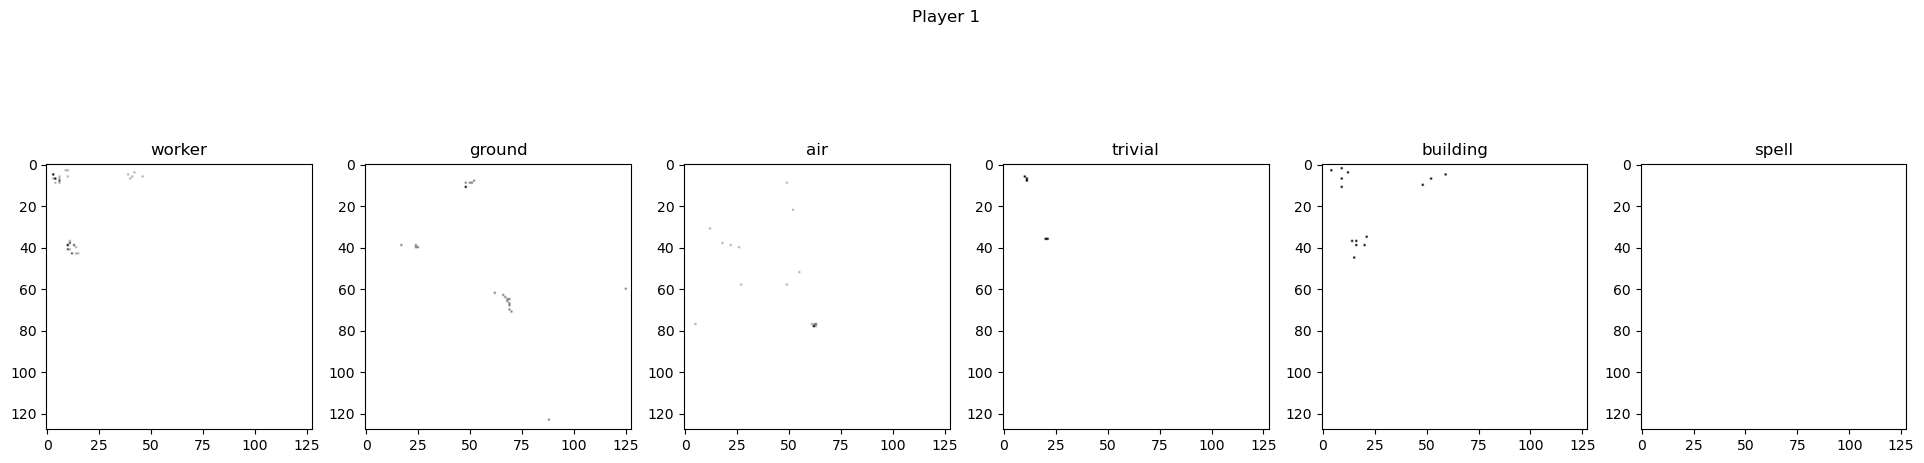

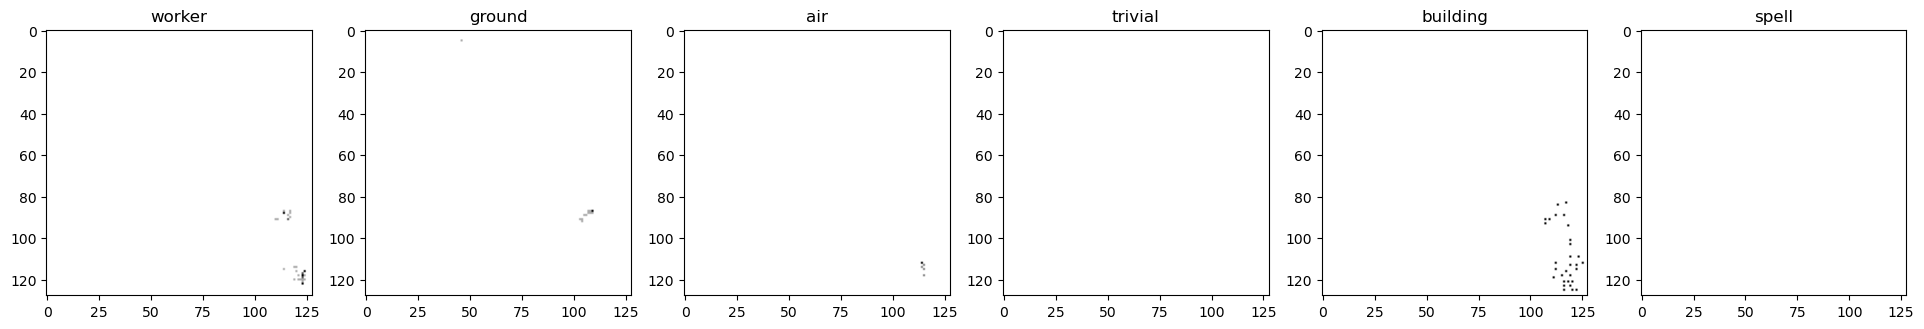

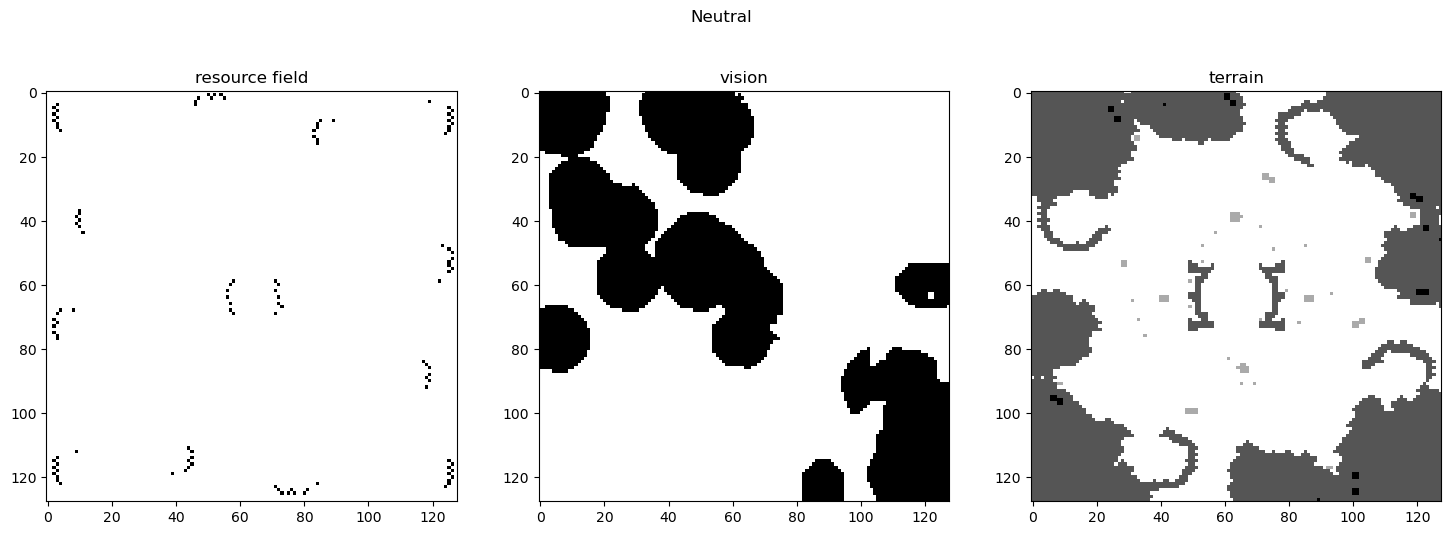

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3531/3531 [06:07<00:00,  9.61it/s]


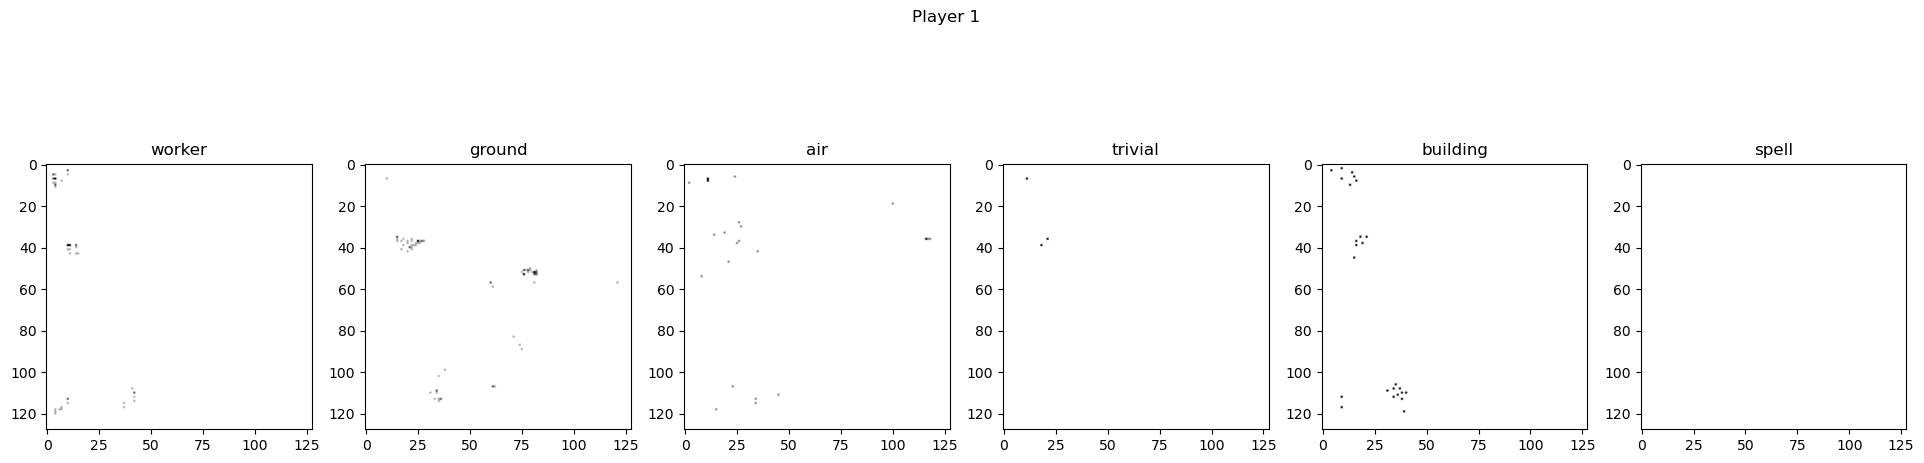

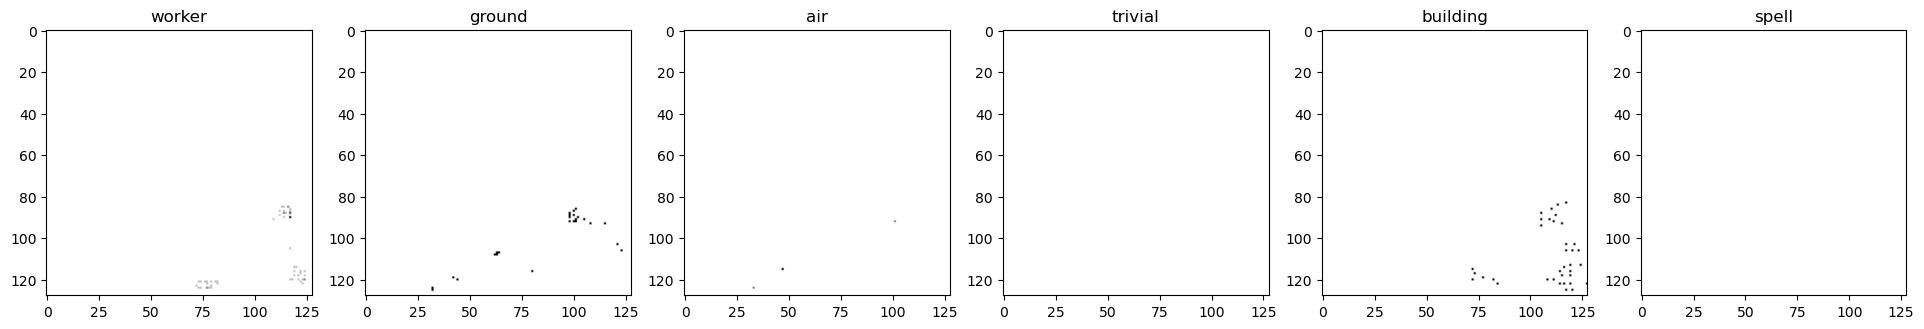

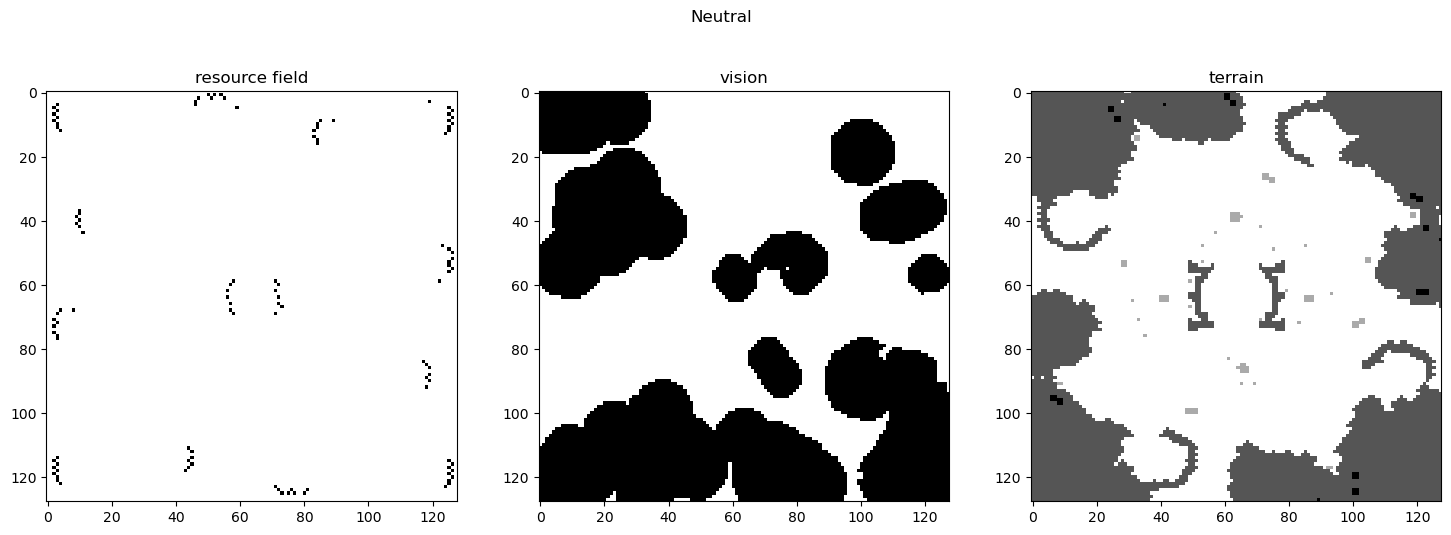

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3541/3541 [05:46<00:00, 10.23it/s]


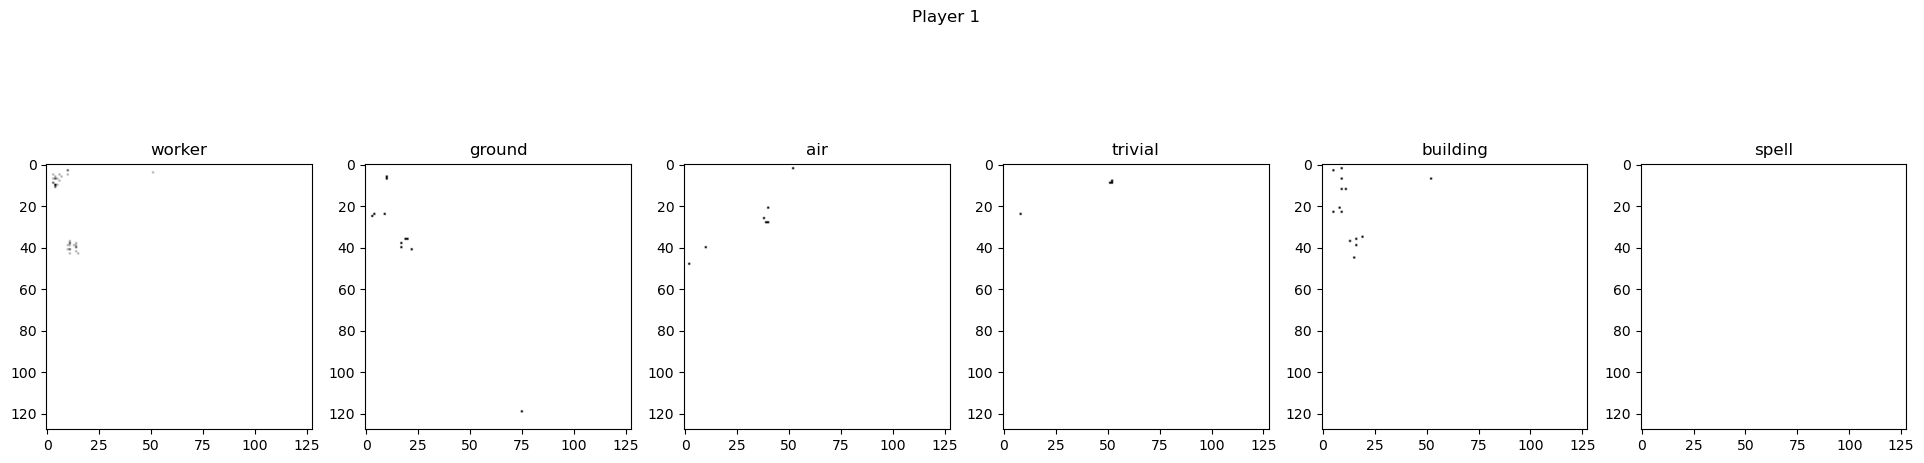

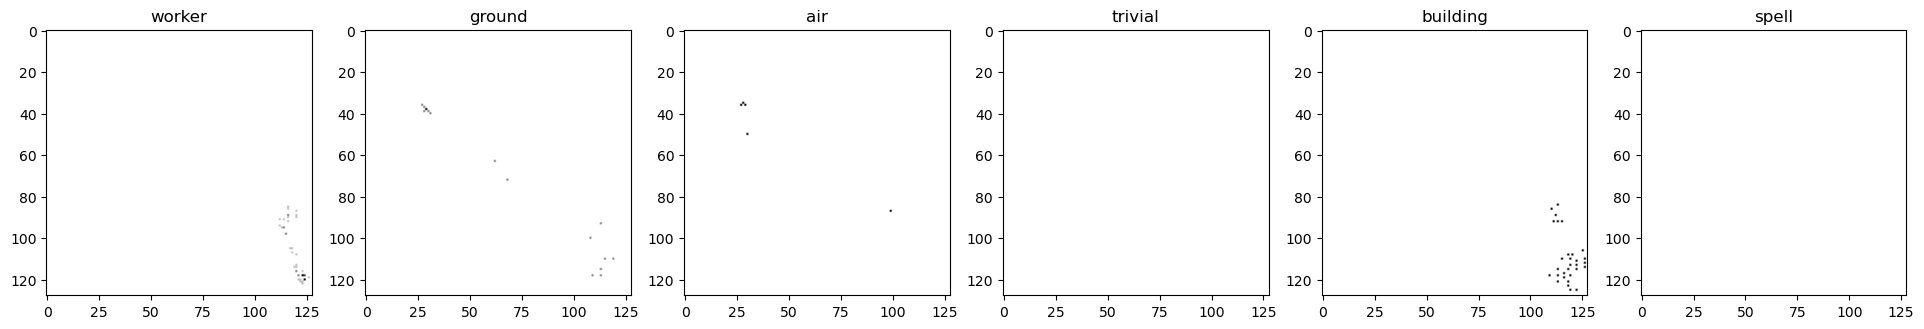

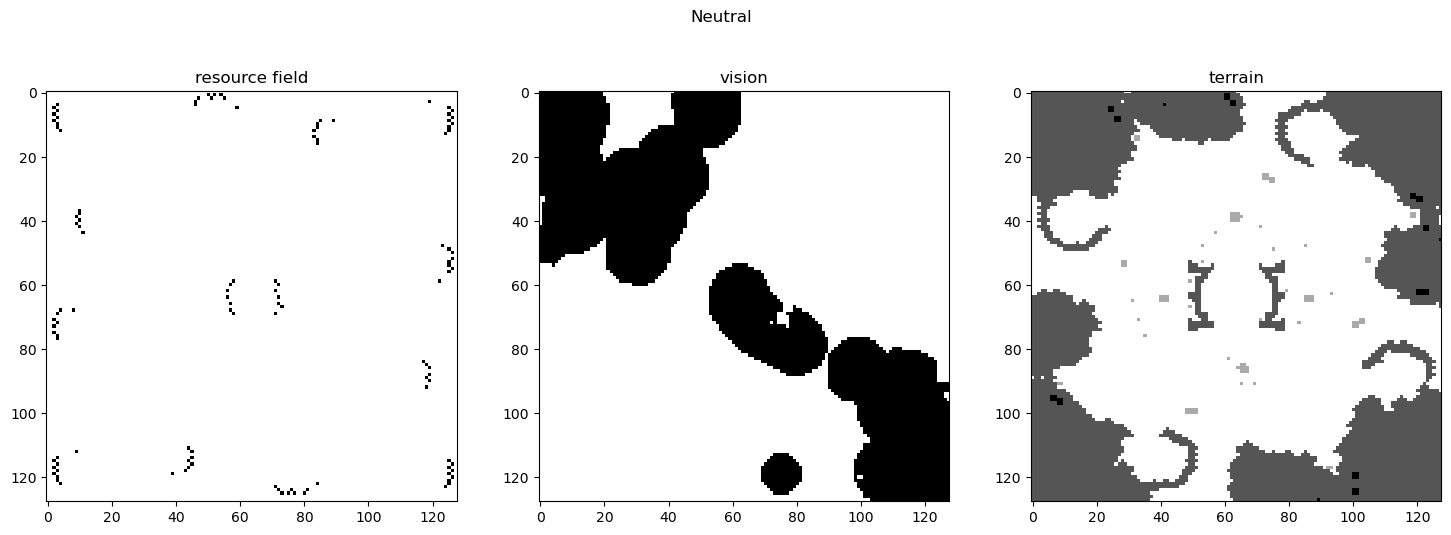

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3111/3111 [05:01<00:00, 10.31it/s]


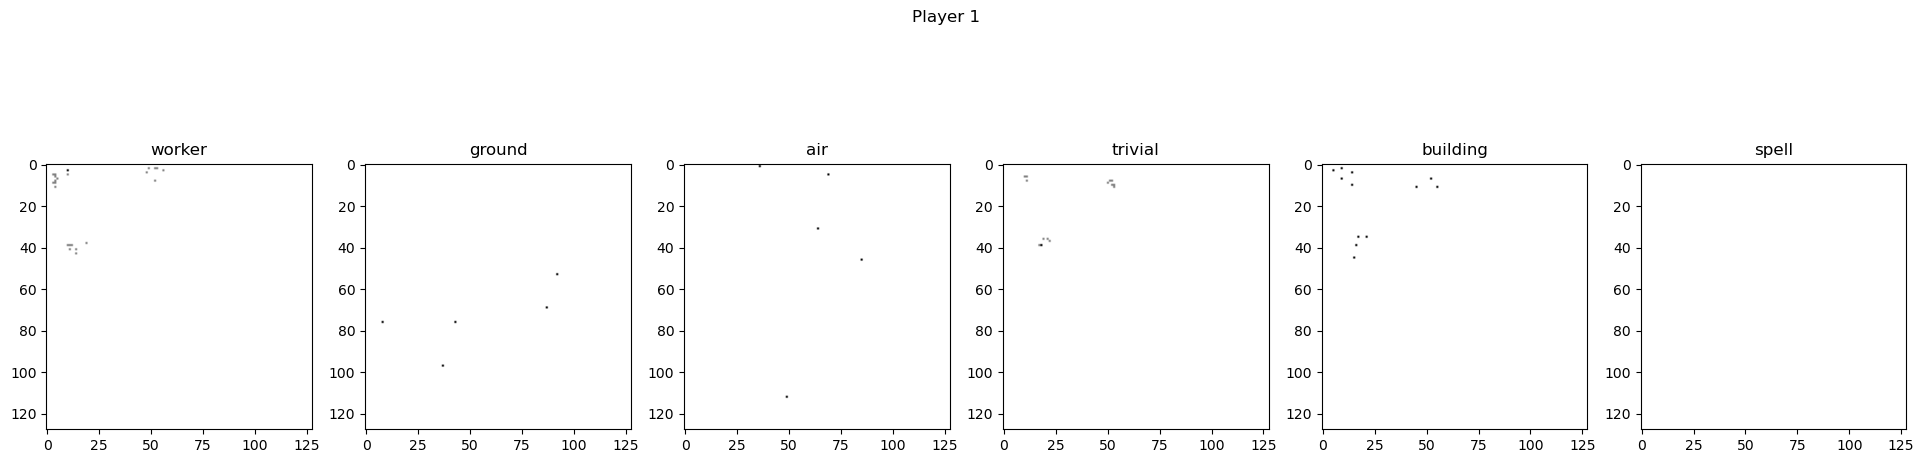

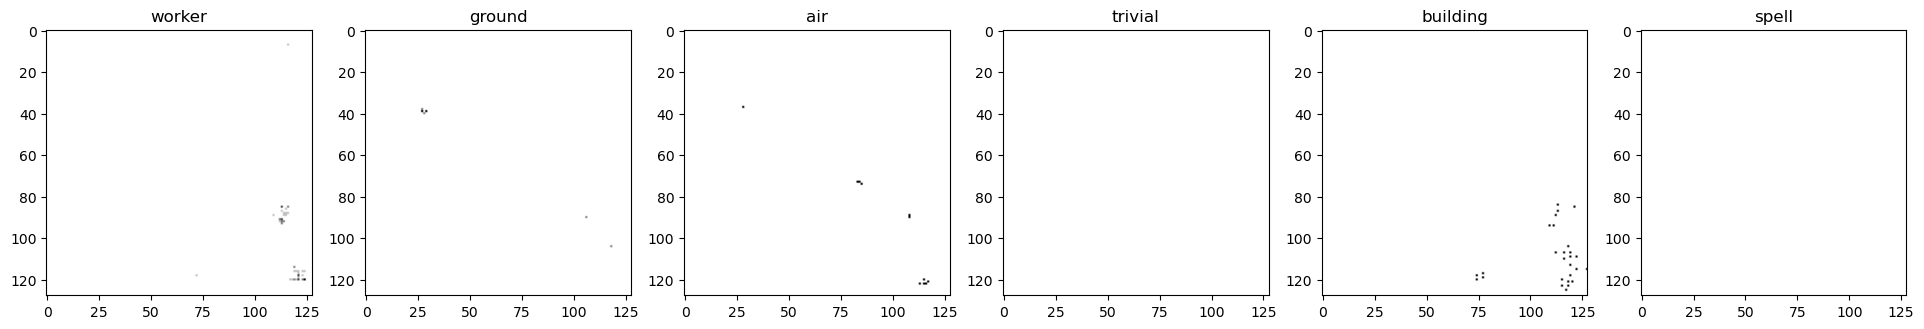

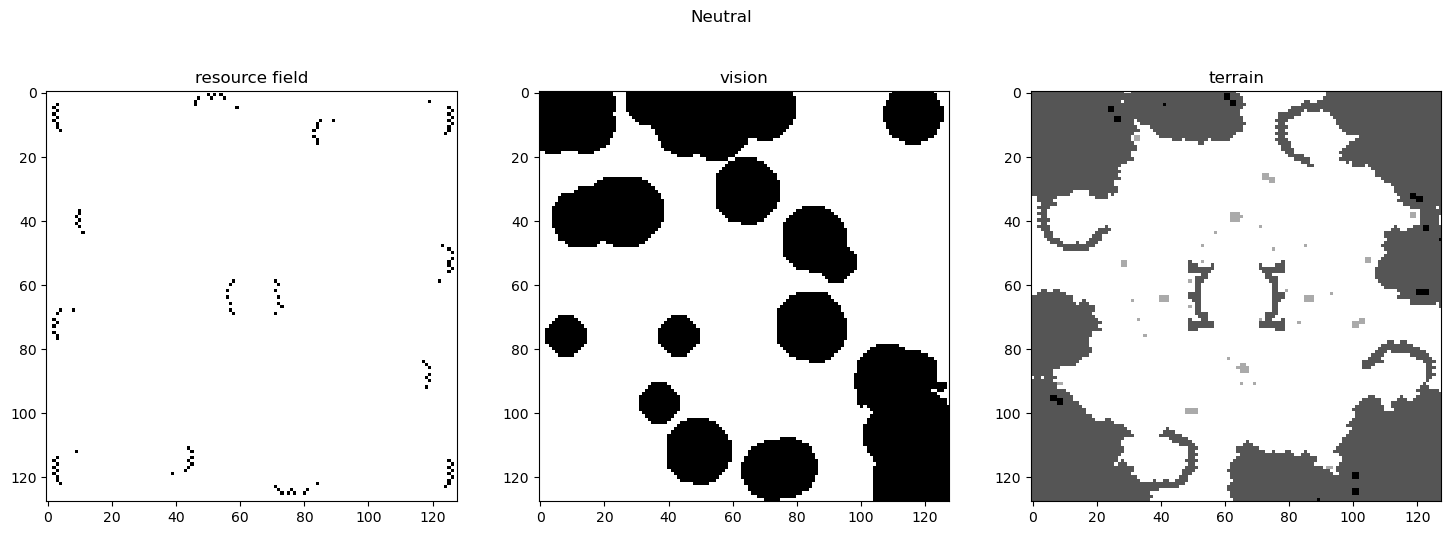

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3749/3749 [06:05<00:00, 10.25it/s]


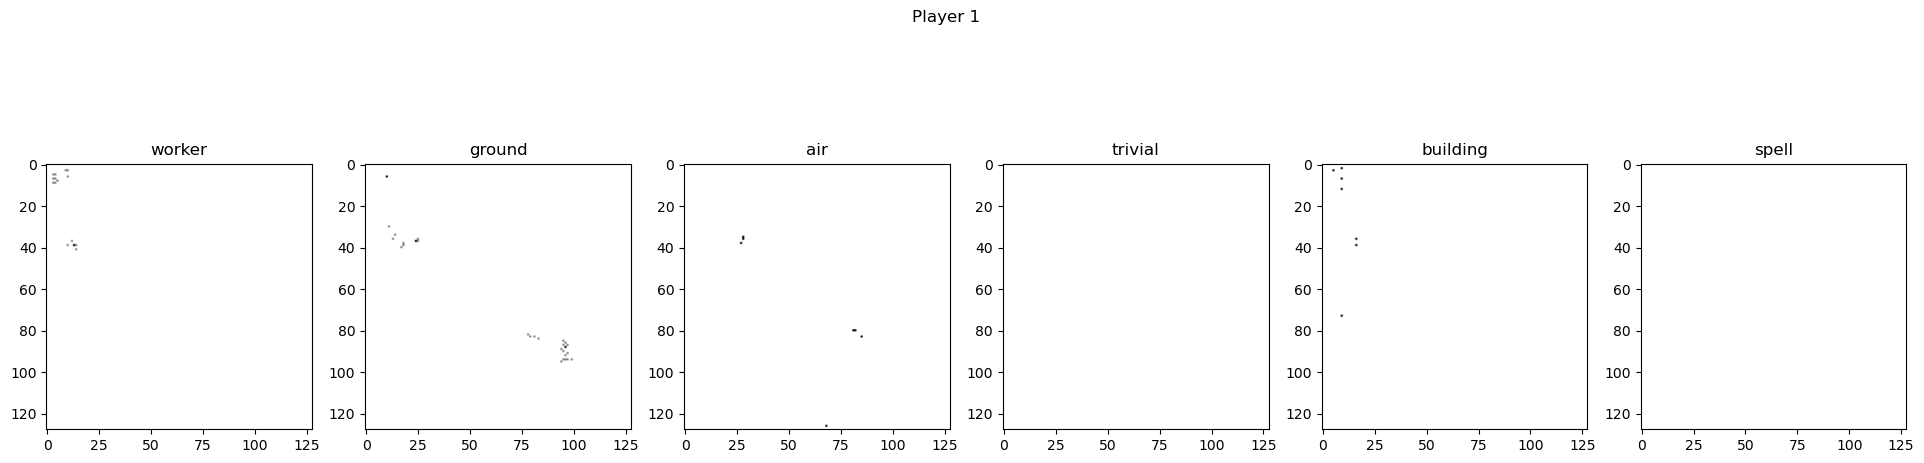

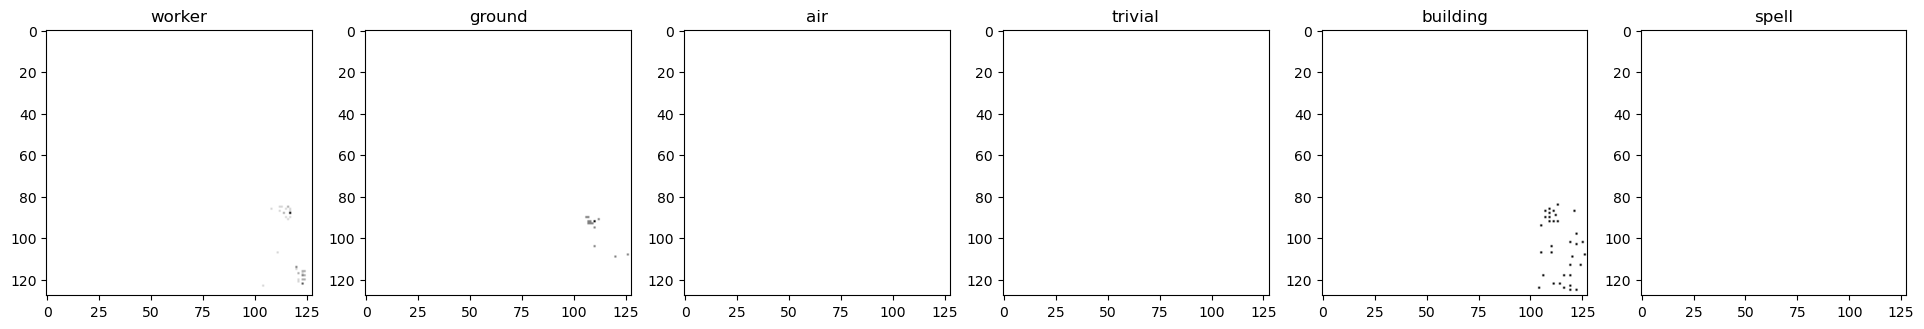

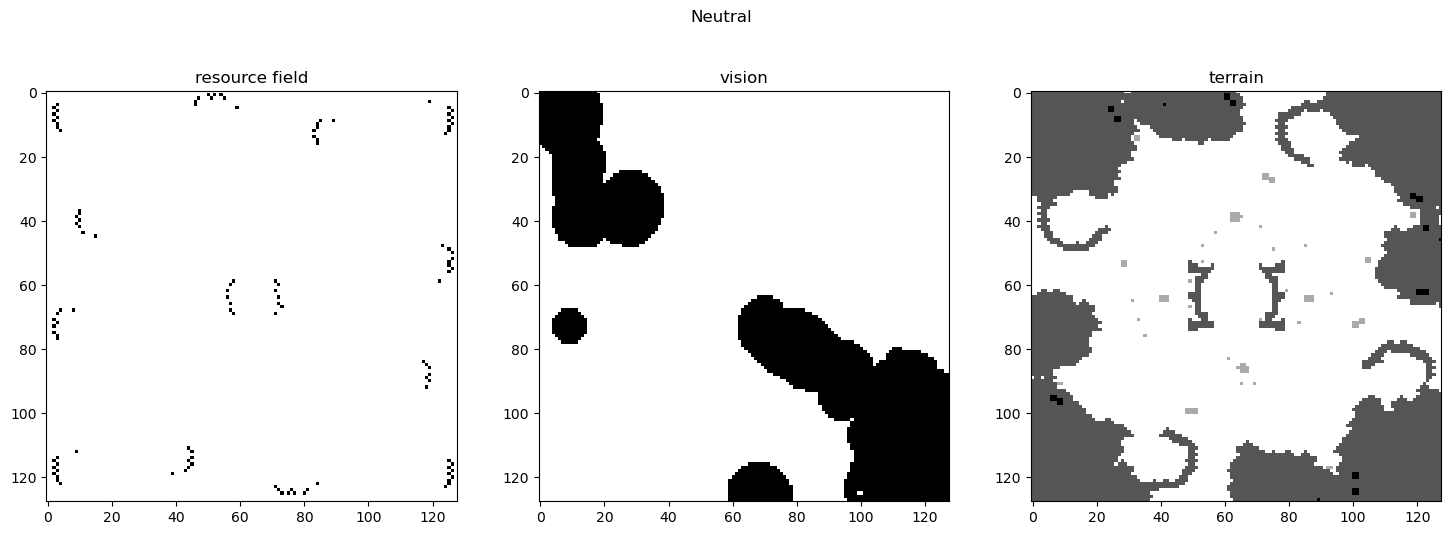

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3486/3486 [05:46<00:00, 10.06it/s]


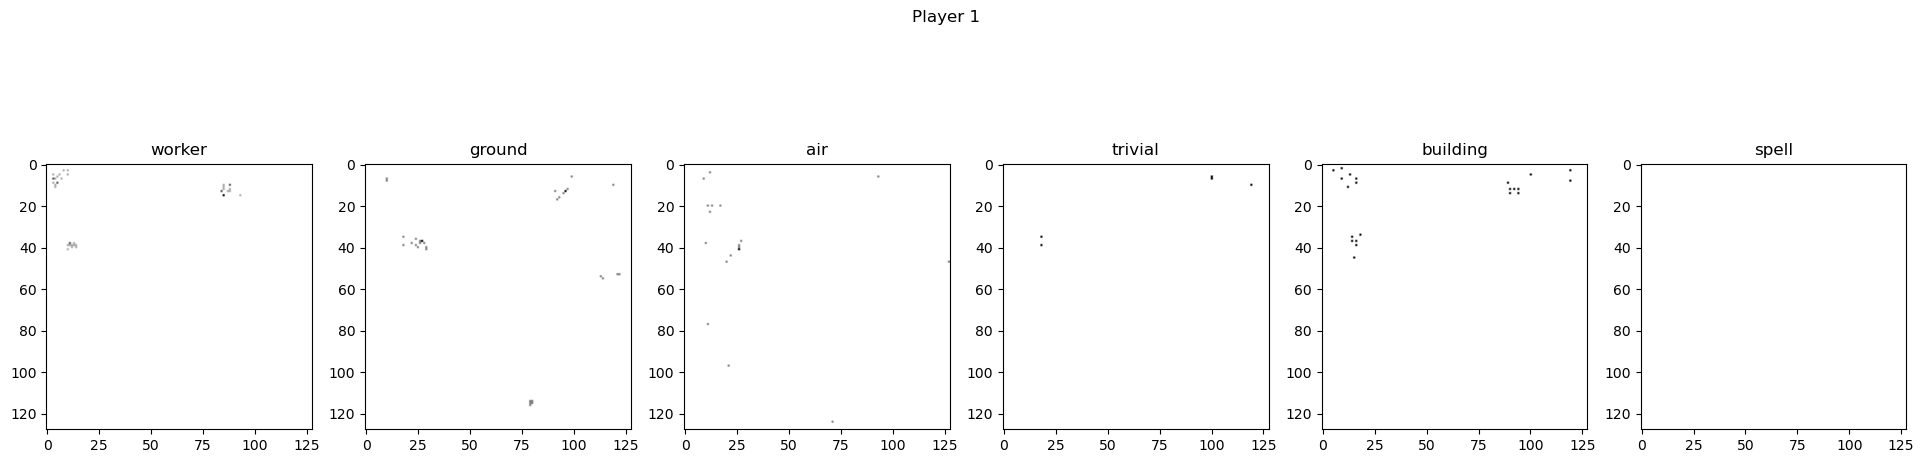

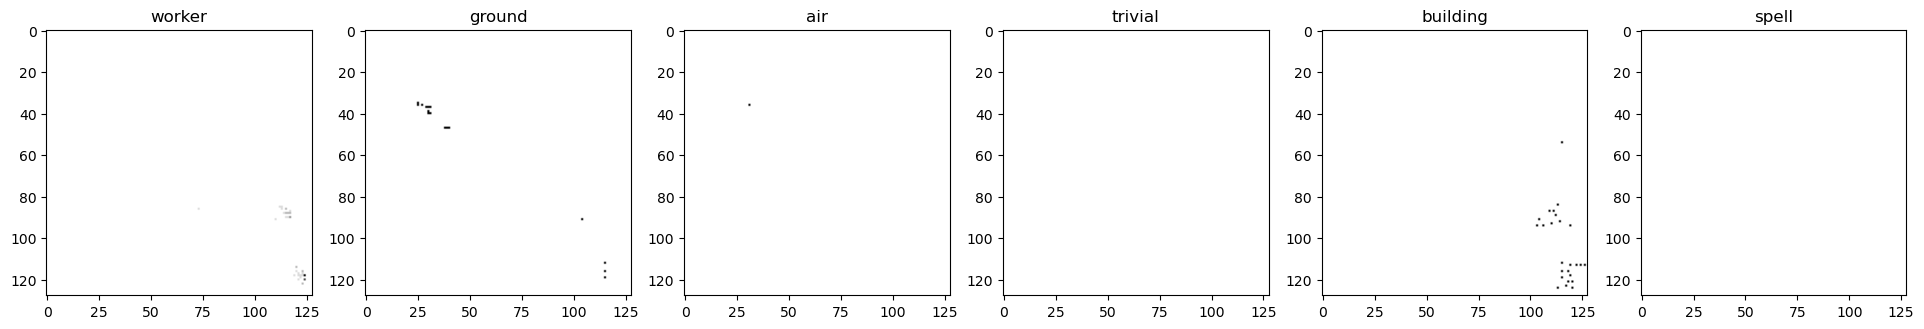

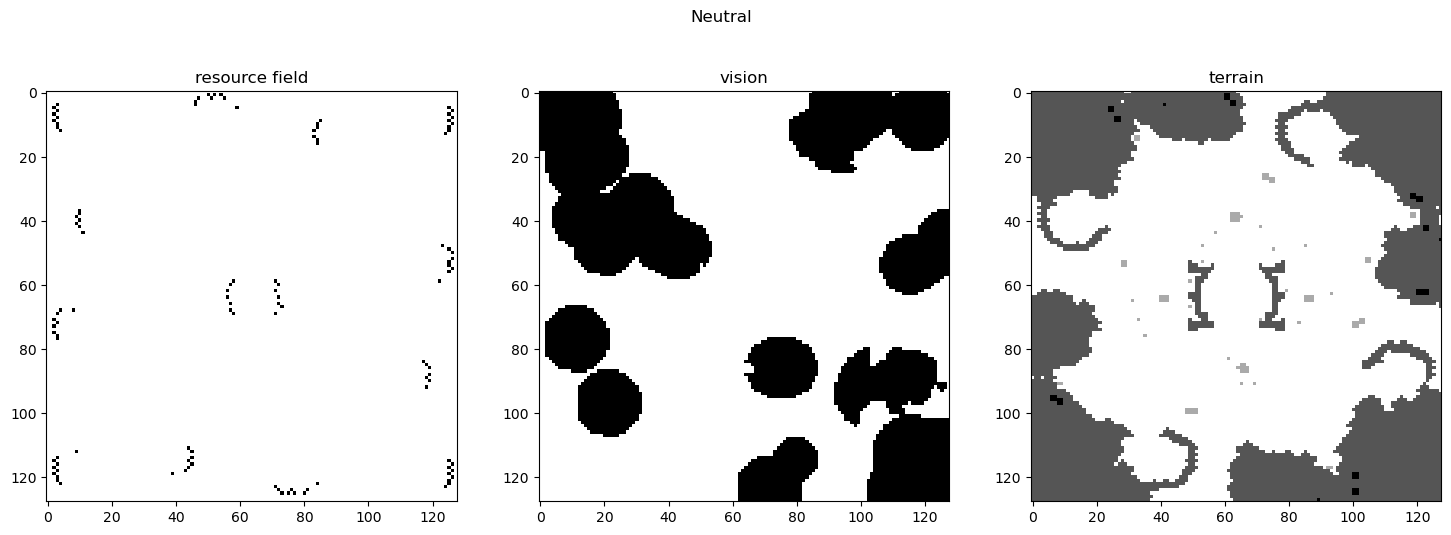

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3107/3107 [05:29<00:00,  9.44it/s]


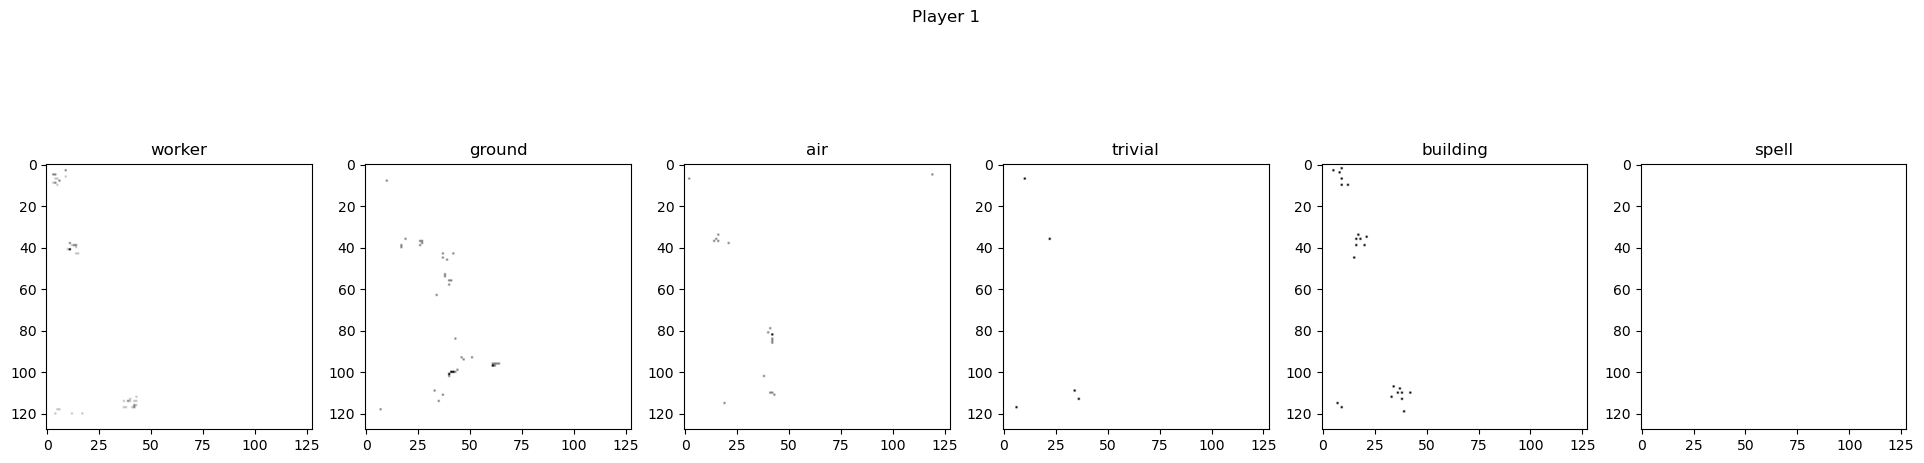

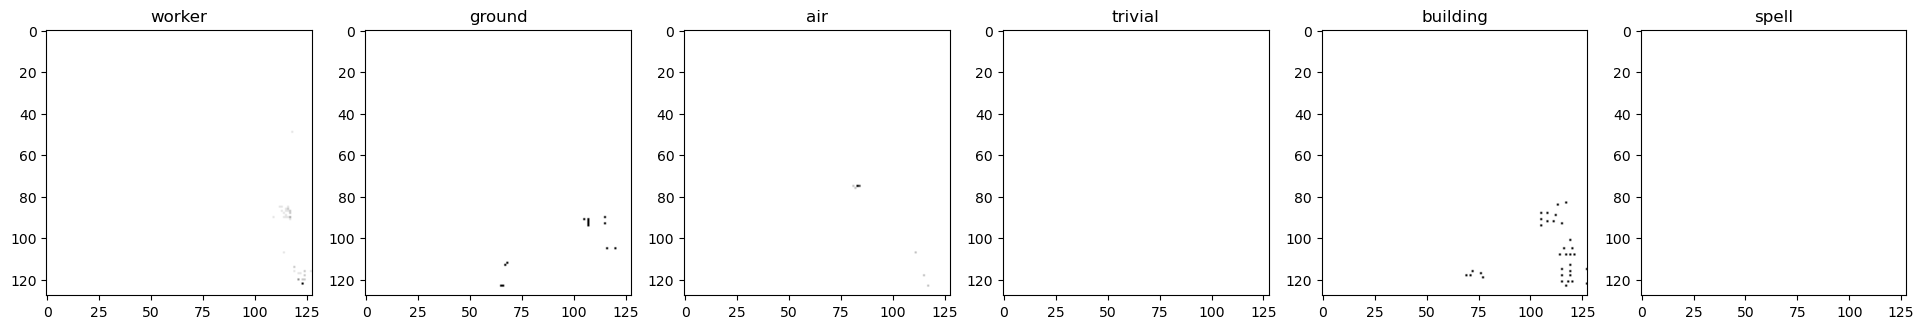

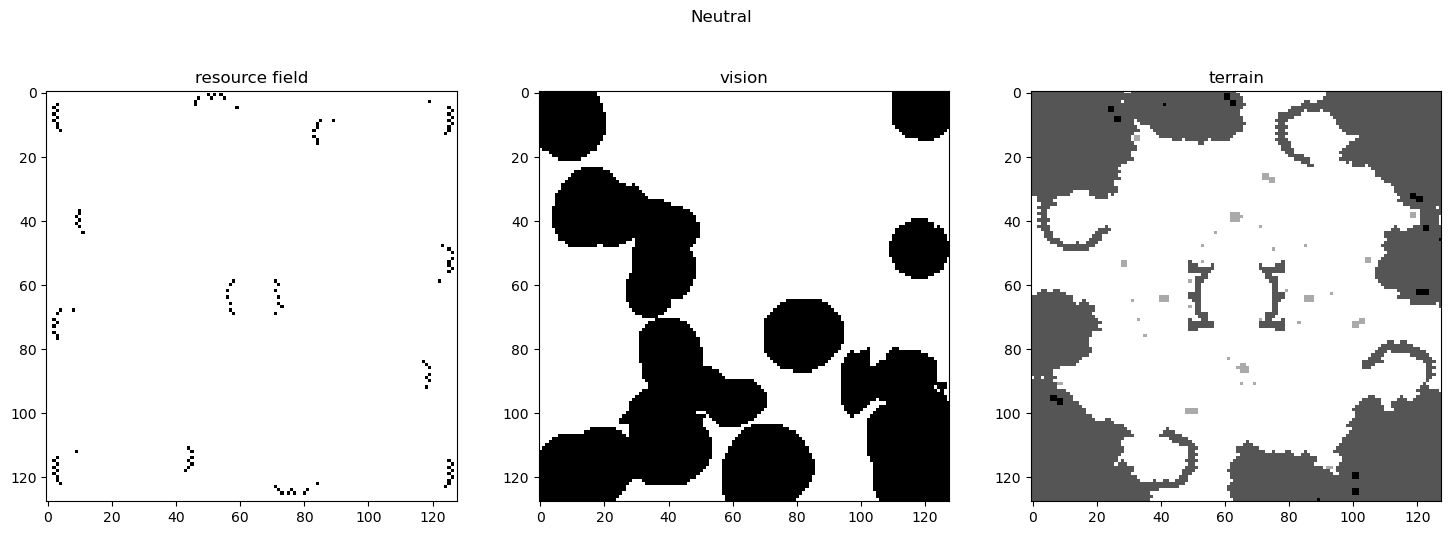

In [27]:
for rep_name in ['1660.rep', '212.rep', '36.rep', '4037.rep', '438.rep', '522.rep', '6254.rep']:
    raw_dataframe, terminal_frame, (terrain_pixel, terrain_tile), vision_dataframe = load_data(rep_name)
    replay_file_number = rep_name.split('.')[0]
    os.makedirs('data_compressed3/{}'.format(replay_file_number), exist_ok=True)
    
    # copy (rep.vpd => data_compressed)
    shutil.copy(data_dir+replay_file_number+'.rep.vpd','data_compressed3/' + replay_file_number+'/'+ replay_file_number +'.rep.vpd')
    
    result = []
    ### load_data에서 # players < 2인 가장 작은 프레임이 terminal_frame으로 계산하여 terminal frame으로 사용함
    for t in tqdm(list(range(0, terminal_frame, INTERVAL))): 
        # RAW DATA
        current_raw_dataframe = raw_dataframe.loc[t == raw_dataframe['frame']]
        
        current_raw_data_channels = raw_dataframe_into_channels(current_raw_dataframe) ###
        # TERRAIN
        current_terrain_tile = np.expand_dims(terrain_tile, 0)
        # VISION
        current_vision_dataframe = vision_dataframe.loc[t == vision_dataframe['frame']]
        current_vision_data_channel = vision_dataframe_into_channel(current_vision_dataframe, terrain_tile.shape)

        # RESULT
        # print(current_raw_data_channels.shape, current_vision_data_channel.shape, current_terrain_tile.shape)
        current_channels = np.vstack([current_raw_data_channels, current_vision_data_channel, current_terrain_tile])
        # print('current frame channels: ', current_channels.shape)
        result.append(current_channels)
        
    result = np.stack(result)
    # np.save(data_dir + '{}.channels'.format(rep_name), result, allow_pickle=True)
    np.savez_compressed('data_compressed3/' + replay_file_number+'/' + '{}.channels_compressed'.format(rep_name), data=result)    
    plot_samples(int(len(result)*0.6))

0. player_1_channel_worker
0. player_1_channel_ground
0. player_1_channel_air
0. player_1_channel_trivial
0. player_1_channel_building
0. player_1_channel_spell

0. player_2_channel_worker
0. player_2_channel_ground
0. player_2_channel_air
0. player_2_channel_trivial
0. player_2_channel_building
0. player_2_channel_spell

0. resource_channel
0. vision_data_channel
0. terrain_tile

In [28]:
# 실제 학습에 사용하는 채널 (0, 1, 2, 4, 6, 7, 8, 10, 13)
